# Problem 3

An anisotropic Poisson problem in a two-dimensional domain $\Omega$ is given by the strong form

$$ 
\newcommand{\bs}[1]{{\boldsymbol{#1}}}
\begin{array}{ll}
-\bs{\nabla} \cdot\left( \bs{A} \bs{\nabla} u\right) &= f \quad
\:\:\text{ in }\Omega, \\ 
u &= u_0  \quad \text{ on } \Gamma,
\end{array}
$$

where the conductivity tensor $\bs{A}(\bs{x})\in \mathbb{R}^{2\times
  2}$ is assumed to be symmetric and positive definite for all
$\bs{x}$, $f(\bs{x})$ is a given distributed source, and $u_0(\bs{x})$
is the source on the boundary $\Gamma$.

Choose $\Omega$ to be a disc with radius 1 around the origin.

Take the source terms to be
$$
f = \exp(-100(x^2+y^2))\quad \text{ and } \quad u_0 = 0.
$$

Use conductivity tensors $\bs{A(x)}$ given by
$$
\bs{A}_1 = \begin{pmatrix}
10 & 0\\
0  &10
\end{pmatrix}
\text{ and }
\bs{A}_2 = \begin{pmatrix}
1  & -5\\
-5 &100
\end{pmatrix}
$$

## Import FEniCS and define the mesh

In [ ]:
import dolfin as dl
import ufl

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline

from hippylib import nb

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

mesh = dl.Mesh("circle.xml")

nb.plot(mesh)

## Define source terms and conductivity tensors

In [ ]:
f = dl.Expression("std::exp(-100.*(x[0]*x[0] + x[1]*x[1]))", degree=5)
u_0 = dl.Constant(0.)

A1 = dl.Constant(((10.0, 0.0),(0.0, 10.0)))
A2 = dl.Constant(((1.0, -5.0),(-5.0, 100.0)))

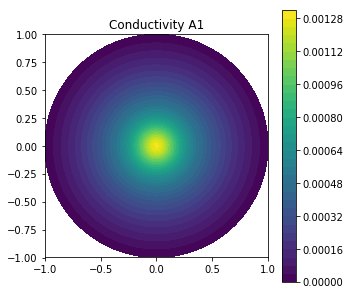

<Figure size 432x288 with 0 Axes>

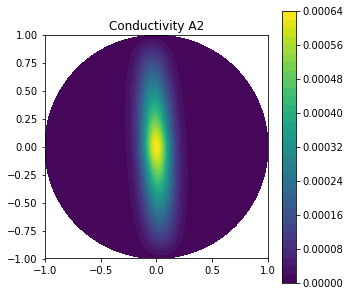

<Figure size 432x288 with 0 Axes>

In [2]:
"""
Computational and Variational Methods for Inverse Problems (Spring 2024)
Assignment-03 -- Question-3 (b)

---> 2D Anisotropic Poisson Problem with domain at unit Circle.

Author: Shreshth Saini (saini.2@utexas.edu)
Date: 10th April 2024
"""

# Question 3(B)
#------------------------------------------------------------------------------------------------------xx------------------------------------------------------------------------------------------------------#

# Compute libraries
import dolfin as dl 
import numpy as np
import mshr 

# general libraries
import matplotlib.pyplot as plt
import logging

# suppress warnings 
import warnings
warnings.filterwarnings("ignore")
#------------------------------------------------------------------------------------------------------xx------------------------------------------------------------------------------------------------------#

# initialize the logger 
logging.getLogger("FFC").setLevel(logging.ERROR)
logging.getLogger("UFL").setLevel(logging.ERROR)
dl.set_log_active(False)


class AnisotropicPoisson2D():
    def __init__(self, mesh_file:str, func_form: str, conduct_tensor:list, space_degree=2, func_degree=4):
        self.mesh_file = mesh_file
        self.space_degree = space_degree
        self.conduct_tensor = conduct_tensor
        self.func_form = func_form
        self.func_degree = func_degree
    
    # defining and solving - flow
    def solution_flow(self):
        # obtaining mesh
        self.get_mesh(self.mesh_file)
        # getting function space 
        self.function_space(self.space_degree)
        # functional equation 
        self.define_functions(self.func_form, self.func_degree)
        # extracting conduct tensors 
        for i in range(len(self.conduct_tensor)):
            self.conduct_tensor[i] = dl.Constant(self.conduct_tensor[i])
        
        # stiffness form 
        self.stiffness_form = []
        for i in range(len(self.conduct_tensor)):
            self.stiffness_form.append(self.generate_forms(self.conduct_tensor[i]))
        
        # rhs form 
        self.rhs_form = self.f*self.v_test*dl.dx
        
        # boundary condition
        self.bc = self.boundary_condition(dl.Constant(0.0), "on_boundary")        
        
        # solving the system of equations 
        self.U = []
        for i in range(len(self.stiffness_form)):
            self.U.append(self.solve_system(self.stiffness_form[i], self.rhs_form, self.bc))

        # make the plots 
        for i in range(len(self.U)):
            self.plot_solution(self.U[i], f"Conductivity A{i+1}")
            
    # generate mesh or load from file     
    def get_mesh(self, mesh_file=None):
        if mesh_file is None:
            self.mesh = self.generate_mesh()
        else:
            self.mesh = dl.Mesh(self.mesh_file)
    
    def generate_mesh(self, type="Circle"):
        # create mesh
        if type == "Circle":
            domain = mshr.Circle(dl.Point(0,0), 1)
            mesh = mshr.generate_mesh(domain, 50)
        else: 
            print(f"Mesh type not implemented.")
            return None
        return mesh
    
    # defining the finite element space 
    def function_space(self, degree=2):
        # defining the function space
        self.V = dl.FunctionSpace(self.mesh, "CG", degree)
        # defining the test and trial functions
        self.u = dl.TrialFunction(self.V)
        # defining the test function 
        self.v_test = dl.TestFunction(self.V)
    
    # defining the functons
    def define_functions(self, func_form, degree=4):
        # defining the functions
        self.f = dl.Expression(func_form , degree=degree) 
    
    # generating the stiffness
    def generate_forms(self, conduct_tensor):
        # defining the bilinear and linear forms
        return dl.inner(dl.dot(conduct_tensor, dl.grad(self.u)), dl.grad(self.v_test))*dl.dx
    
    # boundary condition 
    def boundary_condition(self, u_D, boundary):
        # defining the boundary condition
        bc = dl.DirichletBC(self.V, u_D, boundary)
        return bc
    
    # solve the system 
    def solve_system(self,stiffness_form, rhs, bc):
        # solving the system
        # solution init
        U = dl.Function(self.V)
        dl.solve(stiffness_form == rhs, U, bc)
        return U
    
    # plot the solution 
    def plot_solution(self, U, title="Conductivity not specified"):
        # plot the solution
        plt.figure(figsize=(5,5))
        p = dl.plot(U)
        plt.title(title)
        plt.colorbar(p)
        plt.show()
        plt.savefig(f"{title}.png")

        

# main function 

if __name__ == "__main__":
    # input parameters
    mesh_file = "circle.xml"
    func_form = "exp(-100*(pow(x[0],2)+pow(x[1],2)))"
    conduct_tensor = [((10.0, 0.0),(0.0, 10.0)), ((1.0 ,-5.0),(-5.0,100.0))]
    space_degree = 2
    func_degree = 4
    
    # solving the problem
    anisotropic_poisson = AnisotropicPoisson2D(mesh_file, func_form, conduct_tensor, space_degree, func_degree)
    anisotropic_poisson.solution_flow()
